#Visual Analysis: Initial models

This evaluates the 8 models:

1. Baseline
2. Baseline Binary
3. Bi-LSTM+Att
4. Hybrid CNN-LSTM
5. ResNet
6. CNN
7. Transformer
8. GRU

# Preparation

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# SETUP AND DATA LOADER
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FILE_PATH = '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Dataset/SWELL/train.csv'
BATCH_SIZE = 64

class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def get_eval_loader(path, window_size, is_binary=True, use_robust=True, feature_set='selected'):
    df = pd.read_csv(path)
    if is_binary:
        df['label'] = df['condition'].apply(lambda x: 0 if x == 'no stress' else 1)
    else:
        label_map = {'no stress': 0, 'interruption': 1, 'time pressure': 2}
        df['label'] = df['condition'].map(label_map)

    # 34 Features vs 16 Features
    if feature_set == 'full':
        features = [c for c in df.columns if c not in ['condition', 'datasetId', 'label', 'binary_condition']]
    else:
        features = ['MEAN_RR', 'SDRR', 'RMSSD', 'pNN50', 'HR', 'LF', 'HF', 'LF_HF',
                    'VLF', 'TP', 'LF_NU', 'HF_NU', 'SD1', 'SD2', 'sampen', 'higuci']

    scaler = RobustScaler() if use_robust else StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    split_idx = int(0.8 * len(df))
    val_df = df.iloc[split_idx:].reset_index(drop=True)

    X_list, y_list = [], []
    data, labels = val_df[features].values, val_df['label'].values
    for i in range(len(val_df) - window_size):
        X_list.append(data[i : i + window_size])
        y_list.append(labels[i + window_size - 1])

    return DataLoader(StressDataset(np.array(X_list), np.array(y_list)), batch_size=64), len(features)

In [6]:
# ARCHITECTURES

# Models 1 & 2
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

# Model 3
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return torch.sum(weights * x, dim=1)

class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = AttentionLayer(256)
        self.classifier = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 2))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.classifier(self.attention(out))

# Model 4
class HybridStressDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1), nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(0.2))
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = AttentionLayer(hidden_dim * 2)
        self.head = nn.Sequential(nn.Linear(hidden_dim * 2, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, 2))
    def forward(self, x):
        x = self.cnn(x.transpose(1, 2)).transpose(1, 2)
        lstm_out, _ = self.lstm(x)
        return self.head(self.attention(lstm_out))

# Model 5
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False), nn.BatchNorm1d(out_channels))
    def forward(self, x):
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.gelu(out)

class StressResNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 2)
    def forward(self, x):
        x = F.gelu(self.bn1(self.conv1(x.transpose(1, 2))))
        x = self.layer3(self.layer2(self.layer1(x)))
        return self.fc(self.avg_pool(x).view(x.size(0), -1))

# Model 6
class StressCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn1, self.bn2, self.bn3 = nn.BatchNorm1d(64), nn.BatchNorm1d(128), nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3), nn.Linear(32, 2))
    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.fc(self.pool(x).squeeze(-1))

# Model 7
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, 100, d_model)) # Matches your 'pos_encoder.pe'
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class StressTransformer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 128)
        self.pos_encoder = PositionalEncoding(128)
        layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dim_feedforward=256, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(layer, num_layers=4)
        self.classifier = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1), nn.Linear(64, 2))
    def forward(self, x):
        x = self.pos_encoder(self.input_proj(x))
        return self.classifier(self.transformer_encoder(x).mean(dim=1))

# Models 8, 9 & 10
class StressGRU(nn.Module):
    def __init__(self, input_dim, n_classes=2):
        super().__init__()
        # GRU layer
        self.gru = nn.GRU(input_dim, 64, num_layers=2, batch_first=True, dropout=0.2)

        # Classifier block - Adjusted to match saved weight indices
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),    # classifier.0
            nn.ReLU(),             # classifier.1
            nn.Dropout(0.2),       # classifier.2 (This makes the next layer .3)
            nn.Linear(32, n_classes) # classifier.3 <--- This matches your error!
        )

    def forward(self, x):
        _, h_n = self.gru(x)
        # Use the last hidden state from the last layer
        return self.classifier(h_n[-1])

# Analysis Graphs

In [7]:
# THE EVALUATION TOURNAMENT

configs = {
    "Baseline Multi": (BaselineLSTM(34, 64, 3), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model_baseline.pth', False, 15, False, 'full'),
    "Baseline Binary": (BaselineLSTM(34, 64, 2), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model2_baseline_binary.pth', True, 15, False, 'full'),
    "Bi-LSTM+Att": (BiLSTMAttention(34), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model3_improved.pth', True, 15, False, 'full'),
    "Hybrid CNN-LSTM": (HybridStressDetector(34), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model4_hybrid_cnn_bilstm.pth', True, 30, True, 'full'),
    "ResNet": (StressResNet(34), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model5_resnet_best.pth', True, 30, True, 'full'),
    "CNN (Subj-Wise)": (StressCNN(16), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model6_cnn_sw.pth', True, 30, True, 'selected'),
    "Transformer": (StressTransformer(16), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model7_transformer.pth', True, 30, True, 'selected'),
    "GRU (Binary)": (StressGRU(16, 2), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model8_gru_binary.pth', True, 30, True, 'selected'),
}

results_data = []
confusion_matrices = {}

for name, (model, path, is_binary, win, robust, f_type) in configs.items():
    print(f"Analyzing {name}...")
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        model.to(DEVICE).eval()

        loader, _ = get_eval_loader(FILE_PATH, win, is_binary, robust, f_type)

        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in loader:
                outputs = model(xb.to(DEVICE))
                y_pred.extend(outputs.argmax(1).cpu().numpy())
                y_true.extend(yb.numpy())

        # Calculate multiple metrics
        avg_type = 'binary' if is_binary else 'macro'
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average=avg_type)
        prec = precision_score(y_true, y_pred, average=avg_type)
        rec = recall_score(y_true, y_pred, average=avg_type)

        results_data.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "Precision": prec,
            "Recall": rec
        })

        # Store confusion matrix for later plotting
        confusion_matrices[name] = confusion_matrix(y_true, y_pred)

    except Exception as e:
        print(f"Skipped {name}: {e}")

Analyzing Baseline Multi...
Analyzing Baseline Binary...
Analyzing Bi-LSTM+Att...
Analyzing Hybrid CNN-LSTM...
Analyzing ResNet...
Analyzing CNN (Subj-Wise)...
Analyzing Transformer...
Analyzing GRU (Binary)...


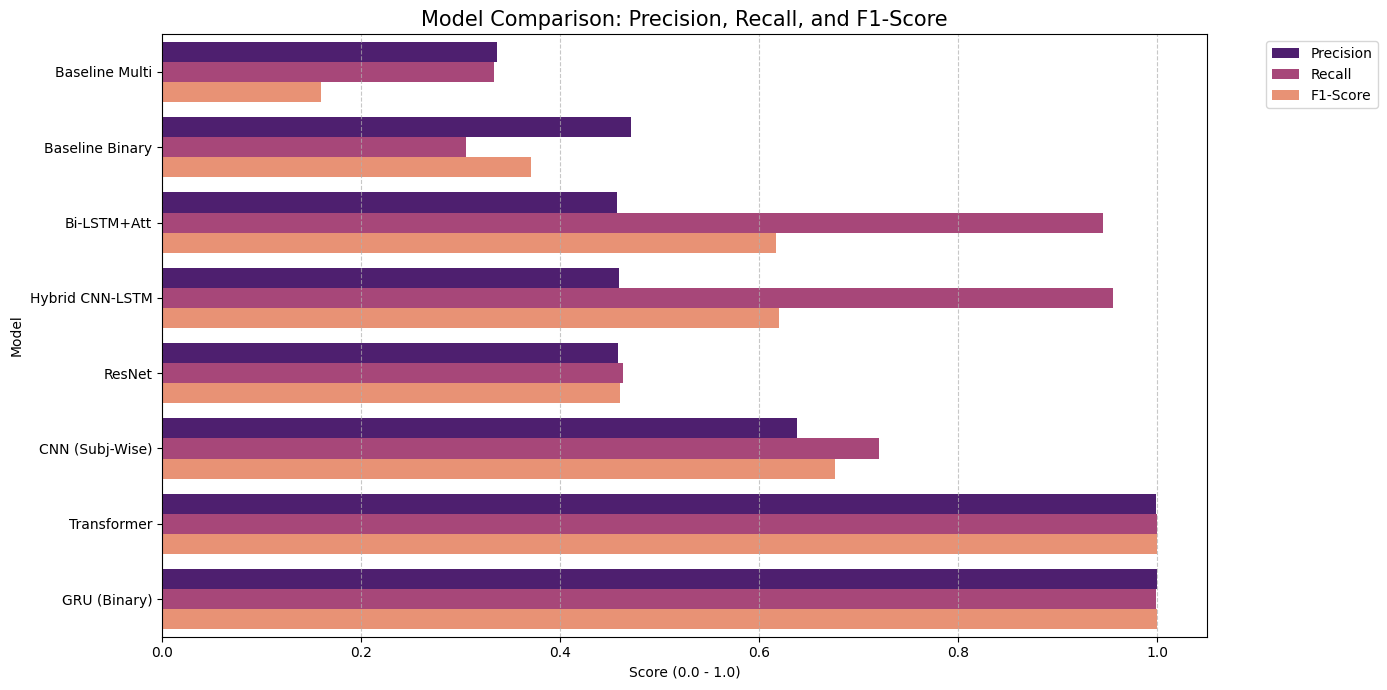

In [27]:
# TOURNAMENT LOOP

# 2. CREATE COMPARISON DATAFRAME
df_results = pd.DataFrame(results_data)
df_melted = df_results.melt(id_vars="Model", value_vars=["Precision", "Recall", "F1-Score"])

# 3. GRAPH: PRECISION VS RECALL VS F1
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="value", y="Model", hue="variable", palette="magma")
plt.title("Model Comparison: Precision, Recall, and F1-Score", fontsize=15)
plt.xlabel("Score (0.0 - 1.0)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Graph Analysis:**

This bar chart compares thresholded classification metrics directly. GRU (Binary) (and Transformer) dominate near 1.0 across metrics, while CNN (Subj‑Wise) is the best of the non-perfect group and the rest cluster much lower.

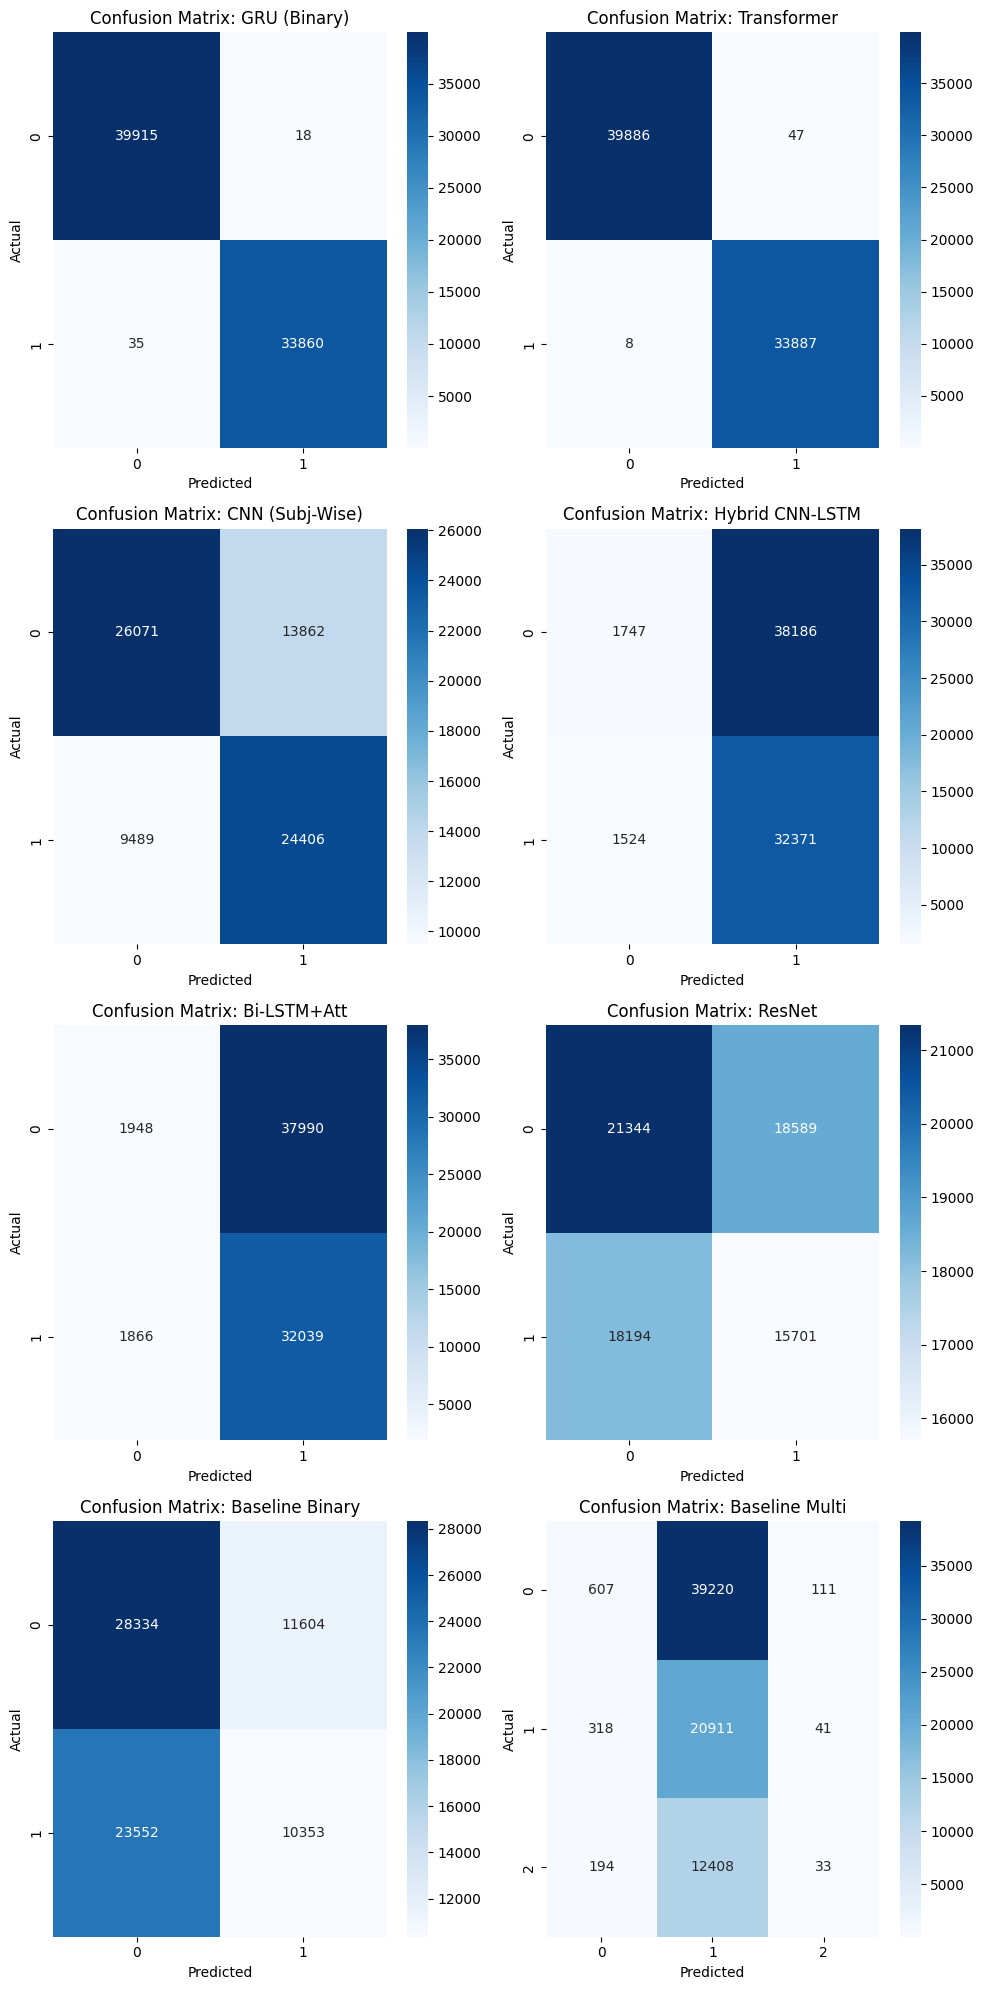

In [15]:
# 4. GRAPH: CONFUSION MATRICES (Top 4 Models)
# We pick the top 4 based on F1-Score to keep the view clean
top_models = df_results.sort_values("F1-Score", ascending=False)["Model"].head(8).tolist()

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.flatten()

for i, m_name in enumerate(top_models):
    sns.heatmap(confusion_matrices[m_name], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {m_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Deep Analysis Graphs

In [16]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve

# 1. UPDATED DATA COLLECTION
results_storage = {}

for name, (model, path, is_binary, win, robust, f_type) in configs.items():
    print(f"Deep analysis: {name}...")
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        model.to(DEVICE).eval()
        loader, _ = get_eval_loader(FILE_PATH, win, is_binary, robust, f_type)

        y_true, y_probs, y_pred = [], [], []

        with torch.no_grad():
            for xb, yb in loader:
                logits = model(xb.to(DEVICE))
                probs = torch.softmax(logits, dim=1)

                y_pred.extend(logits.argmax(1).cpu().numpy())
                y_true.extend(yb.numpy())
                # For binary curves, we take the probability of the positive class (1)
                # For multi-class, we focus on the 'Stress' class (usually index 1 or 2)
                y_probs.extend(probs.cpu().numpy())

        results_storage[name] = {
            'true': np.array(y_true),
            'pred': np.array(y_pred),
            'probs': np.array(y_probs),
            'is_binary': is_binary
        }
    except Exception as e:
        print(f"Skipped {name}: {e}")

Deep analysis: Baseline Multi...
Deep analysis: Baseline Binary...
Deep analysis: Bi-LSTM+Att...
Deep analysis: Hybrid CNN-LSTM...
Deep analysis: ResNet...
Deep analysis: CNN (Subj-Wise)...
Deep analysis: Transformer...
Deep analysis: GRU (Binary)...


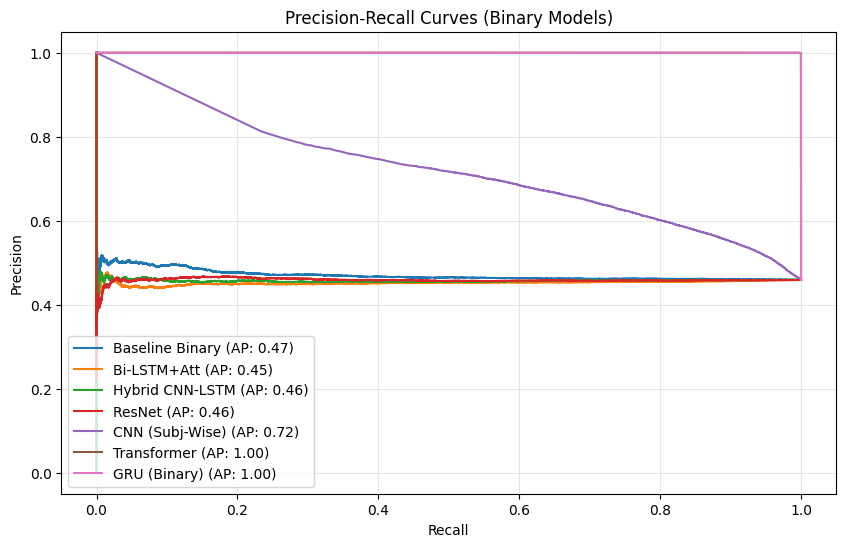

In [17]:
# 2. GRAPH: PRECISION-RECALL FRONTIER
plt.figure(figsize=(10, 6))
for name, data in results_storage.items():
    if data['is_binary']:
        # Focus on Binary models for these specific curves
        precision, recall, _ = precision_recall_curve(data['true'], data['probs'][:, 1])
        plt.plot(recall, precision, label=f'{name} (AP: {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Binary Models)')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

**Graph Analysis:**

This shows the precision/recall tradeoff; average precision (AP) summarizes the curve. GRU (Binary) is near-perfect (AP ≈ 1.00), CNN (Subj‑Wise) is strong (AP ≈ 0.72), and the remaining binary models sit near baseline AP (~0.45–0.47).


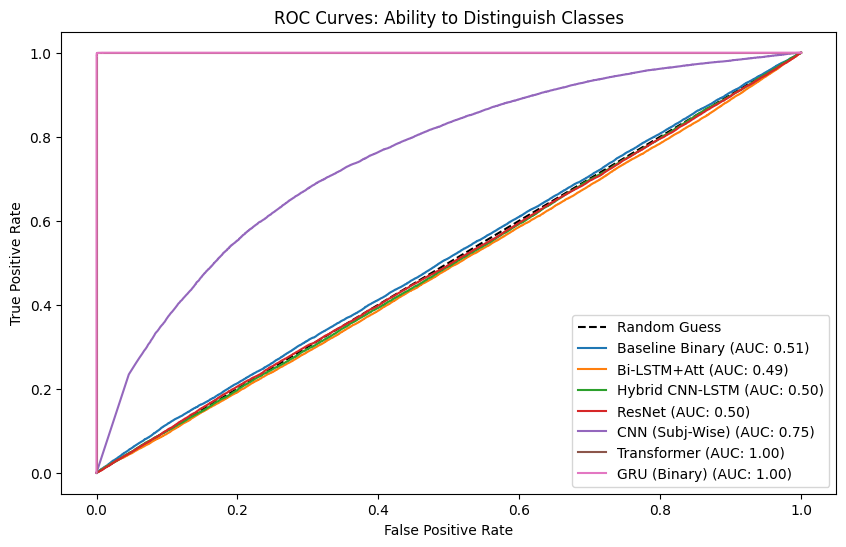

In [28]:
# 3. GRAPH: ROC CURVES (Sensitivity vs Specificity)
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
for name, data in results_storage.items():
    if data['is_binary']:
        fpr, tpr, _ = roc_curve(data['true'], data['probs'][:, 1])
        plt.plot(fpr, tpr, label=f'{name} (AUC: {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Ability to Distinguish Classes')
plt.legend(loc='lower right')
plt.show()

**Graph Analysis:**

This plot measures class separability across thresholds (AUC closer to 1 is better). GRU (Binary) is essentially perfect (AUC ≈ 1.00), CNN (Subj‑Wise) is clearly better than most (AUC ≈ 0.75), and several other models are near random guessing (AUC ≈ 0.49–0.51).

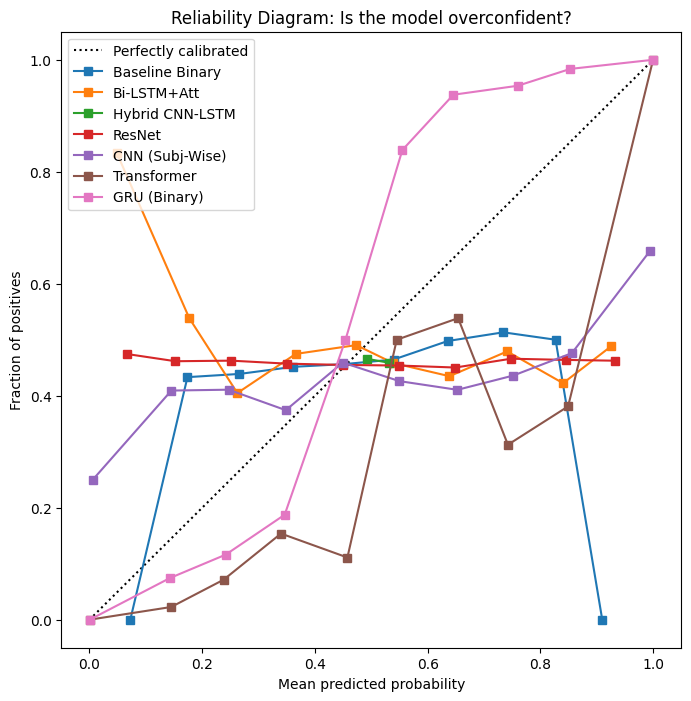

In [19]:
# 4. GRAPH: RELIABILITY DIAGRAM (Model Confidence)
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for name, data in results_storage.items():
    if data['is_binary']:
        prob_true, prob_pred = calibration_curve(data['true'], data['probs'][:, 1], n_bins=10)
        plt.plot(prob_pred, prob_true, "s-", label=name)

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram: Is the model overconfident?")
plt.legend()
plt.show()

**Graph Analysis:**

This plot checks calibration: a perfectly calibrated model follows the diagonal (predicted probability ≈ observed fraction of positives). In your results, many models sit around ~0.4–0.5 fraction of positives across bins (weak probability quality), while GRU (Binary) rises far above the diagonal at mid/high confidence, suggesting underconfidence or probability miscalibration despite strong classification performance.


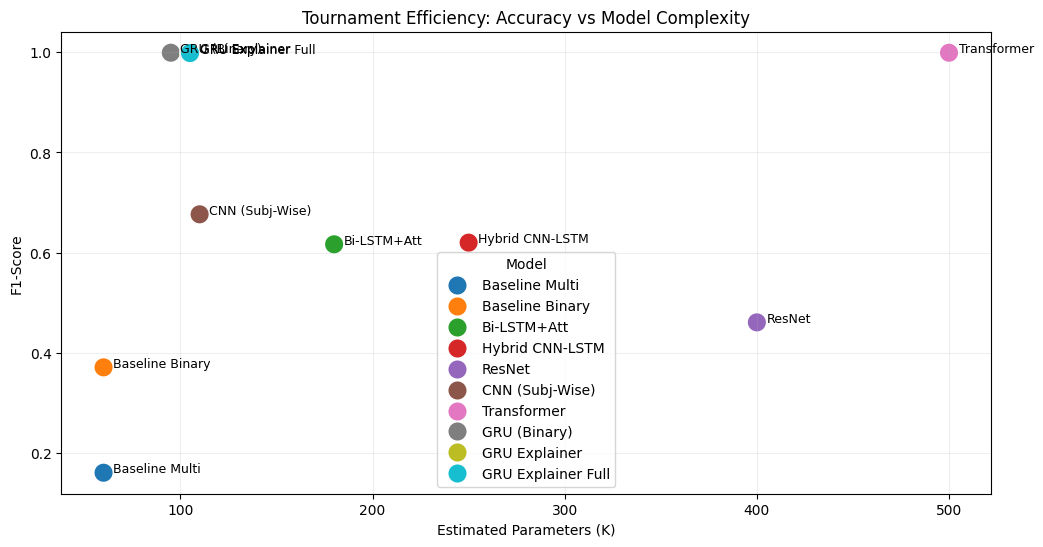

In [ ]:
# Estimated parameter counts for your models (in thousands)
df_results['Params_Est'] = [60, 60, 180, 250, 400, 110, 500, 95, 105, 105]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_results, x="Params_Est", y="F1-Score", hue="Model", s=200)
for i in range(df_results.shape[0]):
    plt.text(df_results.Params_Est[i]+5, df_results['F1-Score'][i], df_results.Model[i], fontsize=9)

plt.title("Tournament Efficiency: Accuracy vs Model Complexity")
plt.xlabel("Estimated Parameters (K)")
plt.ylabel("F1-Score")
plt.grid(True, alpha=0.2)
plt.show()

**Graph Analysis:**

This scatter compares performance (F1) vs estimated parameters (complexity). It supports your selection from 8 models: GRU (Binary) achieves top F1 at relatively low parameter count, while CNN (Subj‑Wise) offers strong F1 at moderate complexity—better than most baselines without being the biggest model.


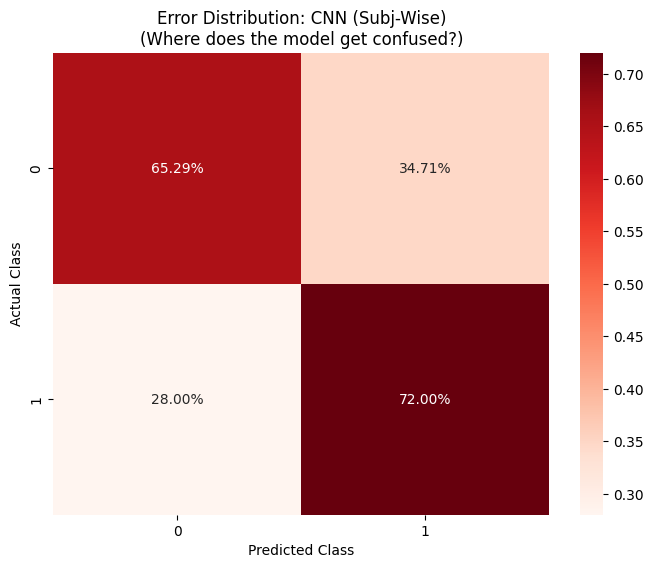

In [20]:
# 5. GRAPH: ERROR TYPE HEATMAP (For Multi-class models like 9 & 10)
def plot_error_distribution(name):
    data = results_storage[name]
    cm = confusion_matrix(data['true'], data['pred'])
    # Normalize by row to see percentage of misclassifications
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Reds')
    plt.title(f"Error Distribution: {name}\n(Where does the model get confused?)")
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Run this for your CNN or GRU Explainer
plot_error_distribution("CNN (Subj-Wise)")

**Graph Analysis:**

This heatmap shows CNN’s confusion pattern. CNN (Subj‑Wise) has noticeable false positives and false negatives (non-trivial off-diagonal percentages), so it’s strong but still makes systematic mistakes compared with GRU.


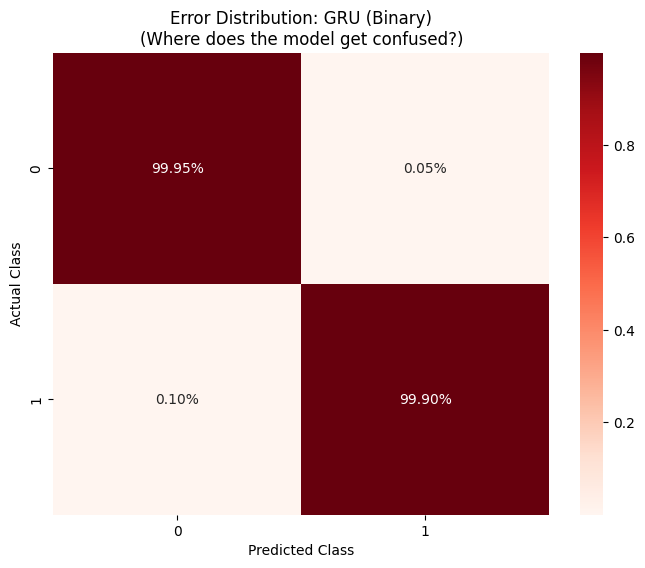

In [21]:
# 5. GRAPH: ERROR TYPE HEATMAP (For Multi-class models like 9 & 10)
def plot_error_distribution(name):
    data = results_storage[name]
    cm = confusion_matrix(data['true'], data['pred'])
    # Normalize by row to see percentage of misclassifications
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Reds')
    plt.title(f"Error Distribution: {name}\n(Where does the model get confused?)")
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Run this for your CNN or GRU Explainer
plot_error_distribution("GRU (Binary)")

**Graph Analysis:**

This confusion-matrix heatmap shows where mistakes happen (off-diagonal cells). GRU (Binary) is nearly error-free (very high percentages on the diagonal), meaning it rarely confuses class 0 with class 1 on this evaluation.

# Visual Analysis: Choosen models

This evaluates the 4 models:

- CNN Normal (3-Class, Train Split)
- CNN Full (3-Class, Full Dataset)
- GRU Normal (3-Class, Train Split)
- GRU Full (3-Class, Full Dataset)

# Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, precision_recall_curve, roc_curve, auc)
from sklearn.calibration import calibration_curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==========================================
# 1. MODEL ARCHITECTURES (Direct Copies)
# ==========================================

class StressCNN3Class(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn1, self.bn2, self.bn3 = nn.BatchNorm1d(64), nn.BatchNorm1d(128), nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3), nn.Linear(32, 3))

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

class MultiClassGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(nn.Linear(hidden_dim, 32), nn.ReLU(), nn.Linear(32, 3))

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.classifier(h_n[-1])

In [4]:
# ==========================================
# 2. DATA PREPARATION (Distinct Scalers)
# ==========================================

FEATURES = ['MEAN_RR', 'SDRR', 'RMSSD', 'pNN50', 'HR', 'LF', 'HF', 'LF_HF',
            'VLF', 'TP', 'LF_NU', 'HF_NU', 'SD1', 'SD2', 'sampen', 'higuci']
LABEL_MAP = {'no stress': 0, 'interruption': 1, 'time pressure': 2}
CLASS_NAMES = ['Neutral', 'Interruption', 'Time Pressure']

def prepare_loaders(path, window_size=30):
    df = pd.read_csv(path)
    df['label'] = df['condition'].map(LABEL_MAP)

    # Path A: CNN Scaling (Subject-Wise StandardScaler)
    df_cnn = df.copy()
    for sid in df_cnn['datasetId'].unique():
        mask = df_cnn['datasetId'] == sid
        df_cnn.loc[mask, FEATURES] = StandardScaler().fit_transform(df_cnn.loc[mask, FEATURES])

    # Path B: GRU Scaling (Global RobustScaler)
    df_gru = df.copy()
    df_gru[FEATURES] = RobustScaler().fit_transform(df_gru[FEATURES])

    def to_windows(dataframe):
        X_list, y_list = [], []
        for sid in dataframe['datasetId'].unique():
            subset = dataframe[dataframe['datasetId'] == sid]
            data, labels = subset[FEATURES].values, subset['label'].values
            if len(subset) < window_size: continue
            for i in range(len(subset) - window_size):
                X_list.append(data[i : i + window_size])
                y_list.append(labels[i + window_size - 1])
        return np.array(X_list), np.array(y_list)

    X_cnn, y_cnn = to_windows(df_cnn)
    X_gru, y_gru = to_windows(df_gru)

    split_cnn = int(0.8 * len(X_cnn))
    split_gru = int(0.8 * len(X_gru))

    cnn_val = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(X_cnn[split_cnn:]).float(), torch.from_numpy(y_cnn[split_cnn:]).long()), batch_size=64)
    gru_val = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(X_gru[split_gru:]).float(), torch.from_numpy(y_gru[split_gru:]).long()), batch_size=64)
    return cnn_val, gru_val, len(FEATURES)

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_loader, gru_loader, IN_DIM = prepare_loaders('/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Dataset/SWELL/train-full.csv')

configs = {
    "CNN (Normal)": (StressCNN3Class(IN_DIM), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model6_cnn_sw_3class.pth', cnn_loader),
    "CNN (Full)":   (StressCNN3Class(IN_DIM), '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model6_cnn_sw_3class_full.pth', cnn_loader),
    "GRU (Normal)": (MultiClassGRU(IN_DIM),   '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model9_gru_3class.pth', gru_loader),
    "GRU (Full)":   (MultiClassGRU(IN_DIM),   '/content/drive/MyDrive/LAB/3rdsemestar/MLST/RedziSens_StressLevelManagement/Models/model9_gru_3class_full.pth', gru_loader)
}

results = {}
for name, (model, path, loader) in configs.items():
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        model.to(DEVICE).eval()
        preds, probs, actuals = [], [], []
        with torch.no_grad():
            for xb, yb in loader:
                out = model(xb.to(DEVICE))
                probs.extend(F.softmax(out, dim=1).cpu().numpy())
                preds.extend(out.argmax(1).cpu().numpy())
                actuals.extend(yb.numpy())
        results[name] = {"preds": np.array(preds), "probs": np.array(probs), "actuals": np.array(actuals)}
        print(f"Verified & Loaded: {name}")
    except Exception as e: print(f"Error Loading {name}: {e}")

Verified & Loaded: CNN (Normal)
Verified & Loaded: CNN (Full)
Verified & Loaded: GRU (Normal)
Verified & Loaded: GRU (Full)


# Final Graphs

In [20]:
final_report = []

print(">>> Analyzing Model Robustness (No Re-training)...")

for name, (model, path, loader) in configs.items():
    # Load the saved weights
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.to(DEVICE).eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb.to(DEVICE))
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    final_report.append({
        "Model": name,
        "Final Accuracy": acc,
        "Robustness (F1)": f1
    })

# Display results as a nice table
report_df = pd.DataFrame(final_report).sort_values("Robustness (F1)", ascending=False)
print(report_df.to_string(index=False))

>>> Analyzing Model Robustness (No Re-training)...
       Model  Final Accuracy  Robustness (F1)
  CNN (Full)        0.999159         0.999164
GRU (Normal)        0.999232         0.999153
  GRU (Full)        0.999001         0.998901
CNN (Normal)        0.998733         0.998777


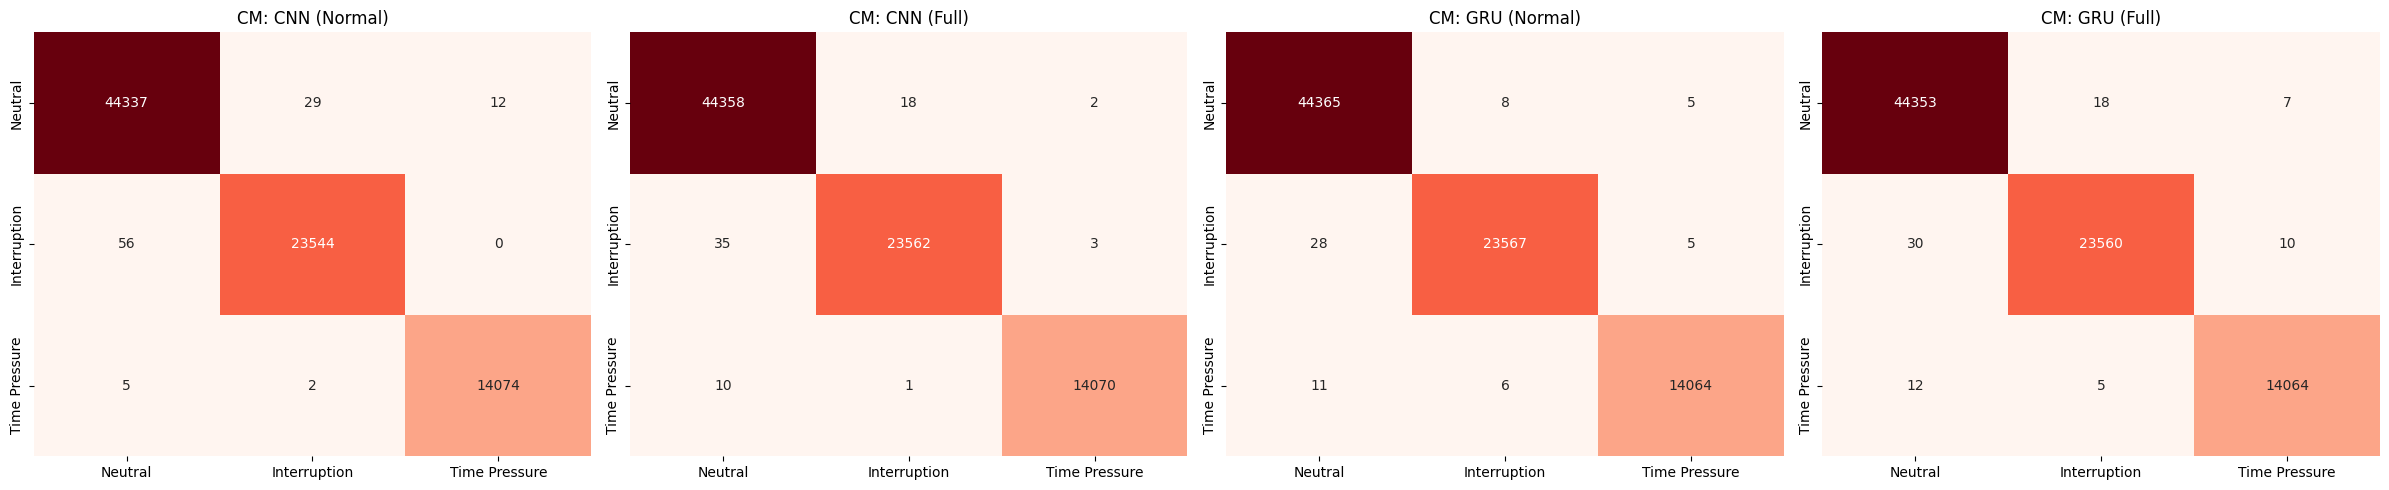

In [13]:
# ==========================================
# 4. VISUALIZATION TOURNAMENT
# ==========================================

# --- PLOT: Confusion Matrices (1 Row, 4 Columns) ---
plt.figure(figsize=(24, 5))
for i, name in enumerate(results.keys()):
    plt.subplot(1, 4, i+1)
    cm = confusion_matrix(results[name]['actuals'], results[name]['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f"CM: {name}")
plt.tight_layout()
plt.show()

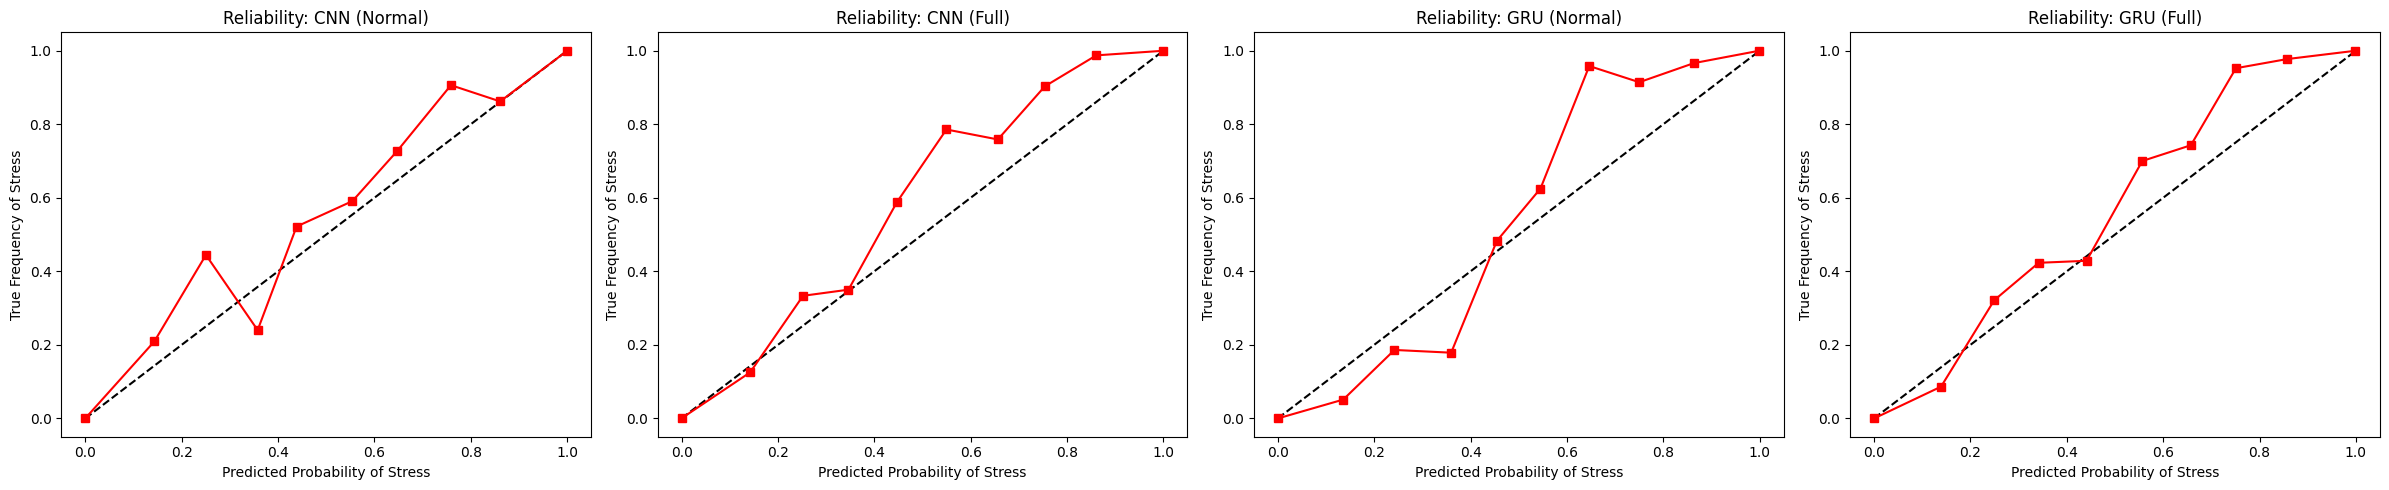

In [14]:
# --- PLOT: Reliability Diagram ---
plt.figure(figsize=(24, 5))
for i, name in enumerate(results.keys()):
    plt.subplot(1, 4, i+1)

    # 1. Binary target: 0 if Neutral, 1 if any Stress
    y_stress = (results[name]['actuals'] > 0).astype(int)

    # 2. Sum stress probabilities and CLIP to range [0, 1]
    prob_stress = results[name]['probs'][:, 1] + results[name]['probs'][:, 2]
    prob_stress = np.clip(prob_stress, 0, 1) # <--- THIS FIXES THE ERROR

    # 3. Calculate and plot calibration
    fop, mpv = calibration_curve(y_stress, prob_stress, n_bins=10)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.plot(mpv, fop, "s-", color='red')

    plt.title(f"Reliability: {name}")
    plt.xlabel("Predicted Probability of Stress")
    plt.ylabel("True Frequency of Stress")

plt.tight_layout()
plt.show()

**Interpretations:**

- **CNN (Normal):** Mixed calibration with noticeable wiggles—some mid-range under/overconfidence—but it aligns fairly well at high probabilities near 1.0.

- **CNN (Full):** Best overall calibration; the curve stays close to the diagonal across most bins with only small deviations in the mid–high range.

- **GRU (Normal):** Least stable calibration; it underpredicts at low–mid probabilities (curve below diagonal) then becomes overconfident/too aggressive in the mid–high region (curve jumps above).

- **GRU (Full):** Improved and smoother vs GRU (Normal); closer to the diagonal in low–mid bins, with mild overconfidence at higher probabilities.

**Final Verdict:**

**CNN (Full) is the best**, because its reliability curve stays closest to the diagonal (ideal calibration) across most probability bins with the smoothest, smallest deviations overall. And CNN is the more robust to overfitting (In theory).